In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, roc_auc_score, roc_curve, recall_score, confusion_matrix, classification_report
import scikitplot as skplt
from scipy import stats
from imblearn.over_sampling import SMOTE

sns.set(style="darkgrid")

plt.rcParams['xtick.major.pad']='9'
plt.rcParams['ytick.major.pad']='9'

%matplotlib inline

In [41]:
path = '/Users/seed/Desktop/git/Classification/Bank_Additional/bank-additional-full.csv'

data = pd.read_csv(path, sep=';')

display(data.head())

print('Instances = {}\n\nFeatures = {}'.format(data.shape[0], data.shape[1]))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Instances = 41188

Features = 21


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [43]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Dataset info:

It is a dataset that describing Portugal bank marketing campaigns results.
Conducted campaigns were based mostly on direct phone calls, offering bank client to place a term deposit.
If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'

Features info:

- age: the age of the target user (between 17 and 98 ages)
- job: type of job (divided in categories) of the target user (admin, blue-collar, technician, services, management, retired, entreprenour, self-employed, housemaid, unemployed, student, unknown)
- marital: civil status of the target user (married, single, divorced, unknown)
- education: education level of the target user (university.degree, high.school, basic.9y, professional.course, basic.4y, basic.6y, unknown, illiterate )
- default: if the target user has a credit in default (yes, no or unknow)
- housing: if the target user has a housing loan (yes, no or unknow)
- loan: if the target user has a personal loan (yes or no)
- contact: telephone means to contact the user (desktop telephone or movil telephone)
- month: month in wich was contacted the target user (March to December)
- day_of_week: weekday in wich was contacted the target user (Monday to Friday)
- duration: last contact duration, in seconds, with the target user (0 to 4918 seconds)
- campaign: number of contacts performed during this campaign and for this client (1 to 56)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (0 to 999)
- previous: number of contacts performed before this campaign and for this client (0 to 7)
- poutcome: outcome of the previous marketing campaign (failure, nonexistent, success)
- emp.var.rate: employment variation rate - quarterly indicator (-3.4 to 1.4)
- cons.price.idx: consumer price index - monthly indicator (92.20 to 94.77)
- cons.conf.idx: consumer confidence index - monthly indicator (-50.80 to -26.90)
- euribor3m: euribor 3 month rate - daily indicator (0.63 to 5.04)
- nr.employed: number of employees - quarterly indicator (4963.60 to 5228.10)

Target:

- y: If the client has subscribed a term deposit (yes or no)



Let's see the values for each categorical column of the dataset

In [44]:
def uniques_val_col(df):
    for col in df:
        print(col,'-----------', data[col].unique(),'\n', sep='\n')

uniques_val_col(df=data.select_dtypes(include='object'))

job
-----------
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']


marital
-----------
['married' 'single' 'divorced' 'unknown']


education
-----------
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']


default
-----------
['no' 'unknown' 'yes']


housing
-----------
['no' 'yes' 'unknown']


loan
-----------
['no' 'yes' 'unknown']


contact
-----------
['telephone' 'cellular']


month
-----------
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']


day_of_week
-----------
['mon' 'tue' 'wed' 'thu' 'fri']


poutcome
-----------
['nonexistent' 'failure' 'success']


y
-----------
['no' 'yes']




There are two categorical columns that has many values: 'job' and 'education'. In jobs columns have sense that have many unique values because the professions described are very different between them and give for our model different information.

But in education column there are unique values that provide to the model  the same information so we are going to group them:

In [45]:
data = data.replace(['basic.4y', 'high.school', 'basic.6y', 'basic.9y'],['basic', 'basic', 'basic', 'basic'])

data.education.unique()

array(['basic', 'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In order to see the correlations with the target value (y)  we are going to change the values of this from numerical to categorical

In [46]:
data = data.replace(['no', 'yes'],[0,1])

data.y.unique()

array([0, 1])

In [47]:
round(data.describe(), 2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04,0.11
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25,0.32
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60,0.00
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10,0.00
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00,0.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10,0.00
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10,1.00


Let's visualize the correlations between some numerical features and the target to see proportions:

Text(0, 0.5, 'Calls')

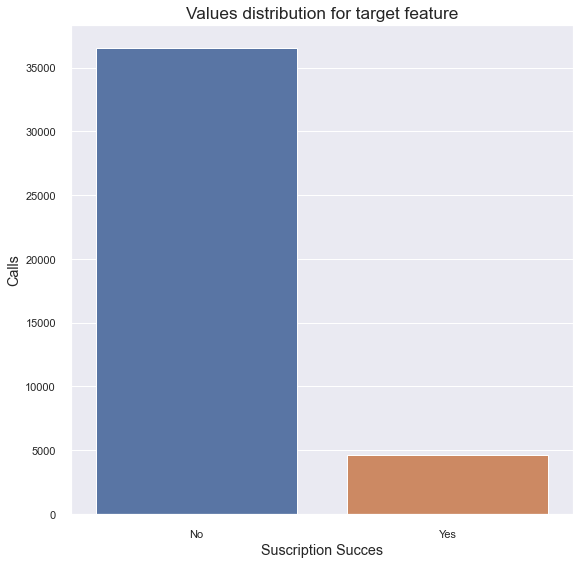

In [56]:
plt.figure(figsize=(9,9))
plt.title('Values distribution for target feature', size='xx-large')
sns.countplot(x='y', data=data)
plt.xticks(np.arange(2), ['No', 'Yes'])
plt.xlabel('Suscription Succes', size='x-large')
plt.ylabel('Calls', size='x-large')

The target variable (y column) is very unbalanced: There are many more 'no' results than 'yes' results and this can be a problem when training the algorithm.

In [57]:
round(data.groupby(by='y').mean(), 2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
0,39.91,220.84,2.63,984.11,0.13,0.25,93.60,-40.59,3.81,5176.17
1,40.91,553.19,2.05,792.04,0.49,-1.23,93.35,-39.79,2.12,5095.12


In [58]:
no = data.y.value_counts()[0]
yes = data.y.value_counts()[1]

pct_yes = round(yes/(no + yes)*100, 2)
pct_no = round(no/(no + yes)*100, 2)

print('Percentage of no subscription = {} %\nPercentage of subscription = {} %'.format(pct_no, pct_yes))

Percentage of no subscription = 88.73 %
Percentage of subscription = 11.27 %


Exploring categorical values

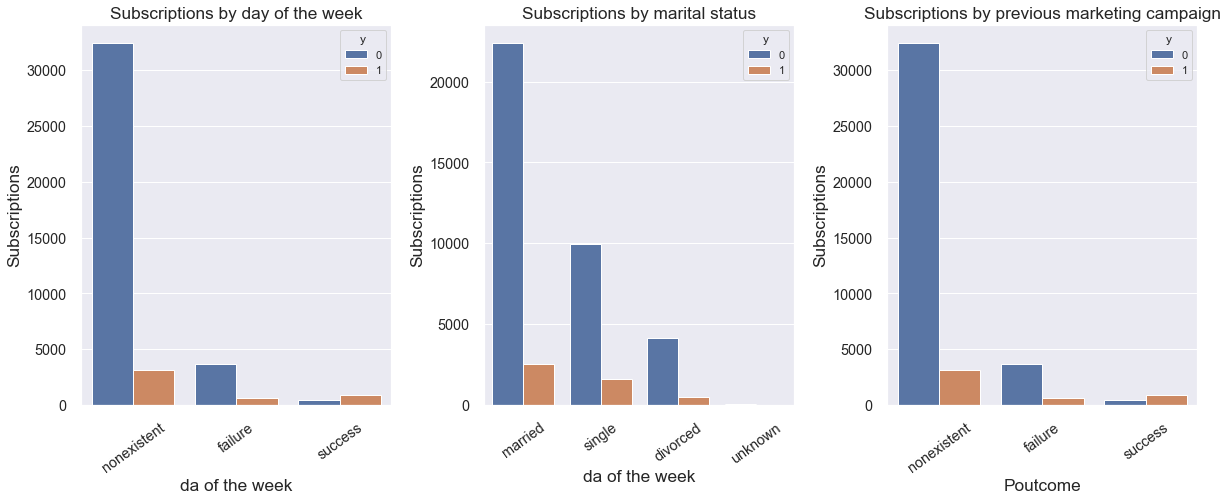

In [59]:
plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace = 0.3)

plt.subplot(131)

sns.countplot(data=data , x='poutcome', hue='y')
plt.title('Subscriptions by day of the week', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('da of the week', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.subplot(132)

sns.countplot(data=data , x='marital', hue='y')
plt.title('Subscriptions by marital status', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('da of the week', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.subplot(133)

sns.countplot(data=data , x='poutcome', hue='y')
plt.title('Subscriptions by previous marketing campaign', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('Poutcome', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.show()

Text(0, 0.5, 'Subscriptions')

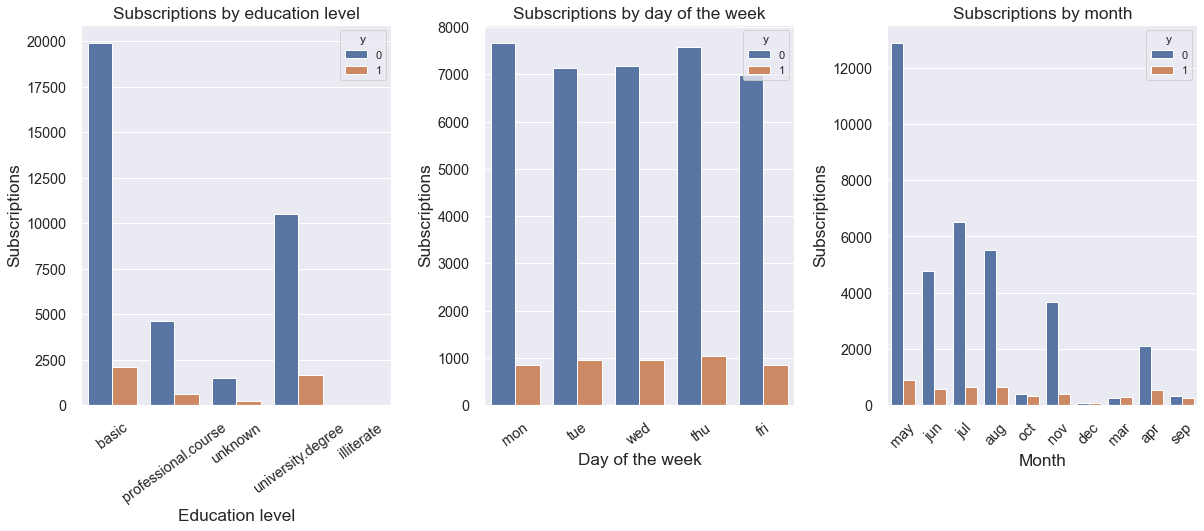

In [60]:
plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace = 0.3)

plt.subplot(131)

sns.countplot(data=data , x='education', hue='y')
plt.title('Subscriptions by education level', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('Education level', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.subplot(132)

sns.countplot(data=data , x='day_of_week', hue='y')
plt.title('Subscriptions by day of the week', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('Day of the week', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.subplot(133)

sns.countplot(data=data , x='month', hue='y')
plt.title('Subscriptions by month', size='xx-large')
plt.xticks(rotation=46, size='x-large')
plt.xlabel('Month', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

As we can see the distribution of the target class is clearly unbalanced, so to fix this we are going to use the SMOTE oversampling technique to get a balanced data after doing the preprocessing of the data.

In [61]:
data.corr().style.background_gradient(cmap='PuBu')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


There are some features that are strong coreelated between them, so maybe we can apply a dimensionality reduction algorithm or apply a penalty l2 in the classification algorithm but there aren't much dimmensions so we are going to avoid this, I think I prefer keep the information because the complexity it'sm not going to be big.

Let's check the correlation specifically between the target value, y, and the others features to have more precission about what variables affects more to the target:

In [62]:
round(data.corr().iloc[:-1,-1], 2)

age               0.03
duration          0.41
campaign         -0.07
pdays            -0.32
previous          0.23
emp.var.rate     -0.30
cons.price.idx   -0.14
cons.conf.idx     0.05
euribor3m        -0.31
nr.employed      -0.35
Name: y, dtype: float64

There are some features like pdays, previous, emp.var.rate or euribor3m that have a correlation between 0 and 0.3 (0 and −0.3), that indicate us a weak positive (negative) linear relationship through a shaky linear rule, that means a weak correlation between they and the target variable.

For other side, the duration of the call has stronger correlation that means moderate linear positive, 0.41, relationship through a fuzzy-firm linear rule. So we can say that the duration of the call is the variable that most affects the result of the y variable, but not much more than the previous ones.

Preprocessing

In [63]:
print(' numerical data --> ', data.select_dtypes(['float', 'int']).columns, '\n'*2, 'categical data --> ', data.select_dtypes(['object']).columns)

 numerical data -->  Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object') 

 categical data -->  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')


For the preprocessing I'm going to use a Pipelines class from Sklearn, with an useful classes that have found in the web (Honestly don't remember where, even if was in a book or web page but if you know it please let me know to put the author because is an amazing job and and I want to thank him and acknowledge his merit!) for selecting the columns, fill the null values (We don't have it this time, but I leave you the class here and where it would fit in the pipeline because it can be very useful for you. It is made 'so that the value with which it is filled is the most frequent, but you can easily replace it according to your criteria by modifying it in the class), and transform the categorical values to numerical values with the class categorical encoder (We are going to use in the class Pandas get_dummies, but again you can replace it for another like label encoder for example).

In [64]:
data_features, target = data.iloc[:,0:-1], data.iloc[:, -1]

class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy == 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    df = X 
    df = df.select_dtypes(include=['object'])
    for column in df.columns:
      self.categories[column] = df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)

num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int')),
    ("scaler", StandardScaler())
                      ])

cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
                      ])

full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])

features_processed = full_pipeline.fit_transform(data_features)

print("Shape = {} \nNew dimmensions = {}".format(features_processed.shape, (features_processed.shape[1] - data_features.shape[1])))

Shape = (41188, 45) 
New dimmensions = 25


Before making the pipeline, we have separated the target columns from the features because I have seen that as we previously transformed them to binary numerical values, when passing them through the pipeline and making the standardisation, many values changed and the number of 1's dropped significantly, so as it was already processed in numerical values I decided to separate the y corresponding to the target variable, process the features through the pipeline and then put them back together again after process the features variables.

In [65]:
data_processed = np.concatenate([features_processed, np.vstack(target.values)], axis=1) 

np.unique(data_processed[:,-1], return_counts=True) # As we can see below, the y values hasn't changed

(array([0., 1.]), array([36548,  4640]))

And it looks in this way:

In [66]:
data_processed # It's ready for the algorythm!!

array([[ 1.53303429,  0.01047142, -0.56592197, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.62899323, -0.42150051, -0.56592197, ...,  1.        ,
         0.        ,  0.        ],
       [-0.29018564, -0.12451981, -0.56592197, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.53303429, -0.26722482, -0.20490853, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.38152696,  0.70856893, -0.56592197, ...,  1.        ,
         0.        ,  1.        ],
       [ 3.26029527, -0.07438021,  0.15610492, ...,  0.        ,
         0.        ,  0.        ]])

### Oversampling with SMOTE

Earlier we have seen that the target variable is very unbalanced (there are many more not than yes) so we are going to use the synthetic sampling technique SMOTE to balance the values:

In [67]:
X = data_processed[:,0:-1]
y = data_processed[:,-1]

os = SMOTE()
X, y = os.fit_resample(X, y)

In [68]:
no = 0
yes = 0

for value in y:
    if value == 0:
        no += 1
    else:
        yes += 1

print("Number of total instances = {}".format(yes+no))
print("Number of 'no' (suscription) class = {} (Proportion = {})".format(no, (no/(yes+no))))
print("Number of 'yes' (suscription) class = {} (Proportion = {})".format(yes, (yes/(yes+no))))

Number of total instances = 73096
Number of 'no' (suscription) class = 36548 (Proportion = 0.5)
Number of 'yes' (suscription) class = 36548 (Proportion = 0.5)


The SMOTE method has created with a few lines of code the necessary instances to match the target variable in a 50/50 ratio of negative and positive class.

We are now going to test the data in different algorithms and measuring the results:

## LOGISTIC REGRESSION

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr = LogisticRegression()

# Going to test RandomizedSearch class to test it, and looks for the better parameters for our Logistig Regression classifier between the values we estimate 

model_params = {
    'C' : [0, 0.5, 1],
    'l1_ratio': [0, 0.5, 1],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

rand = RandomizedSearchCV(lr, param_distributions=model_params, return_train_score=True, n_iter=10, iid=True).fit(X_train, y_train)

print('Best parameters: ', rand.best_params_)
print('Best estimator: ', rand.best_estimator_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalt

In [70]:
lr = LogisticRegression(C=1, l1_ratio=0.5, solver='lbfgs').fit(X_train, y_train)

lr.score(X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8514296137534771

Let's see how the model generalizes through the cross validation score:

In [71]:
cross = cross_val_score(lr, X_train, y_train, cv=5)

def mean_crossval_kfolds(x):
    avg_score = 0
    for i in x:
        avg_score += i/len(x)

    print(' Averaged score: ', avg_score, '\n', 'k-folds scores: ', x)

mean_crossval_kfolds(x=cross)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalt

Let's take a look to the performance measures for our algorithm:

In [72]:
# let's check the confusion matrix first, which will tell us in absolute terms how many times our algorithm is right and wrong in       classifying.

predictions = lr.predict(X_test)

cm = confusion_matrix(y_test, predictions)

print(' True Posituves:  ', cm[1,1],'\n', # times the algorithm is correct in classifying the positive class
      'True Negatives:  ', cm[0,0],'\n',  # times the algorithm is correct in classifying the negative class
      'False Positives: ', cm[0,1],'\n',  # times the algorithm makes a mistake in classifying the positive class
      'False Negatives: ', cm[1,0])       # times the algorithm makes a mistake in classifying the negative class

 True Posituves:   9210 
 True Negatives:   9461 
 False Positives:  1564 
 False Negatives:  1694


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

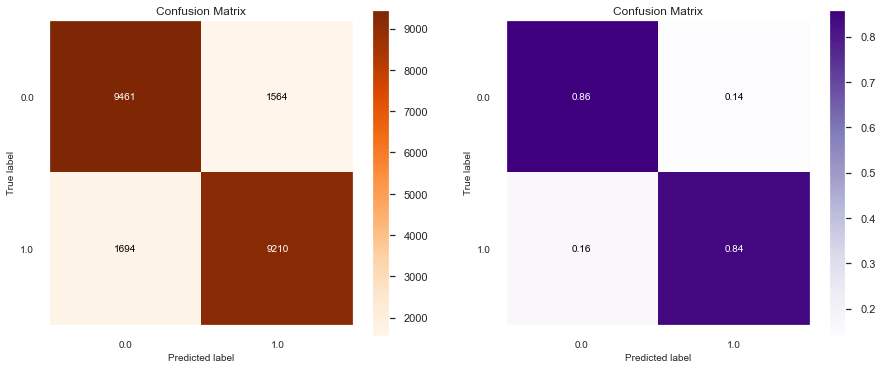

In [73]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
skplt.metrics.plot_confusion_matrix(y_test, predictions,
                                    title="Confusion Matrix",
                                    cmap="Oranges",
                                    ax=ax1)

ax2 = fig.add_subplot(122)
skplt.metrics.plot_confusion_matrix(y_test, predictions,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax2)

Now let's check the performances measures four our logistic regression classifier:

In [74]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85     11025
         1.0       0.85      0.84      0.85     10904

    accuracy                           0.85     21929
   macro avg       0.85      0.85      0.85     21929
weighted avg       0.85      0.85      0.85     21929



- Recall (Or sensitivity) means how many of this class you find over the whole number of element of this class. 

- Precision will be how many are correctly classified among that class. Is the accuracy of the predictions.

- f1-score is the harmonic mean (Inverse of the mean) between precision & recall. The armonic mean considers all the values of the distribution and for some cases it's more representative that the arithmetic mean but is more influenced by small values. The f1 score favors classifiers that have similar precission and recall, like in this case. 

- Support is the number of occurence of the given class in your dataset (so we have 10934 of class 0 and 10995 of class 1, which is a really well balanced dataset. Thanks SMOTE!).

In order to have a clear view about this performance measures, and explain what is the precission-recall trade off lets plot the Precission-Recall Curve and the Receiver Operating Characteristic (ROC) Curve:

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


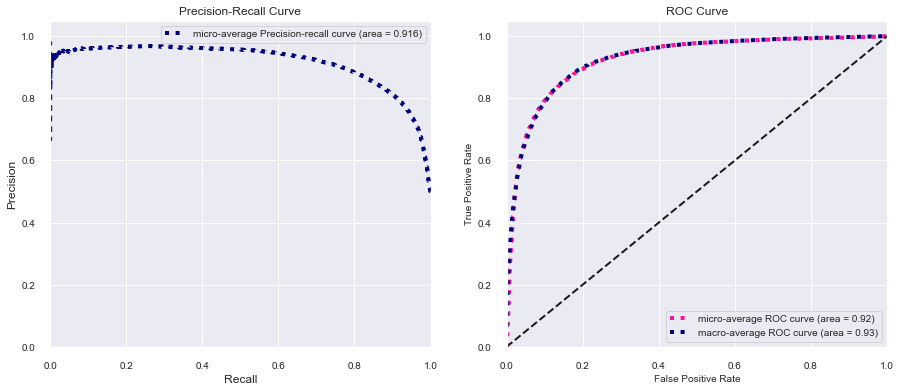

In [105]:
fig = plt.figure(figsize=(15,6))

y_test_probs = lr.predict_proba(X_test)

ax1 = fig.add_subplot(121)
skplt.metrics.plot_precision_recall(y_test, y_test_probs,
                       title="Precision-Recall Curve", classes_to_plot=[0, 'No', 1, 'Yes'], ax=ax1);

ax2 = fig.add_subplot(122)
skplt.metrics.plot_roc(y_test, y_test_probs,
                       title="ROC Curve", classes_to_plot=[0, 'No', 1, 'Yes'], ax=ax2);

# BONUS: Improve the results if we remove the outliers with the Z-score method?

In [107]:
round(data.describe(), 2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04,0.11
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25,0.32
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60,0.00
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10,0.00
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00,0.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10,0.00
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10,1.00


The decribe method give us dispersions measures for numerical features. We are going to create a sub-set from the original with the numerical features with a high rate of variance in order to find the significative outliers. With descibe() we can see the max, min and the quantiles for select features with high rate of variance to find the z-scores for them.

I think that we must take a sight to 'age', 'duration', 'campaign', 'previous' because the distance between their third and fourth quantil is significative and calculate the z-score for them.

In [109]:
data_var = data[['age', 'duration', 'campaign', 'previous']]

z = np.abs(stats.zscore(data_var))

z

array([[1.53303429, 0.01047142, 0.56592197, 0.34949428],
       [1.62899323, 0.42150051, 0.56592197, 0.34949428],
       [0.29018564, 0.12451981, 0.56592197, 0.34949428],
       ...,
       [1.53303429, 0.26722482, 0.20490853, 0.34949428],
       [0.38152696, 0.70856893, 0.56592197, 0.34949428],
       [3.26029527, 0.07438021, 0.15610492, 1.67113606]])

The array from above tell us the the z-score from all the instances and features, so now if we fix a threshold for z-score, making a mask we could identify the position of outliers in the array.

In [110]:
np.where(z > 3)

(array([   37,    75,    83, ..., 41178, 41183, 41187]),
 array([1, 1, 1, ..., 3, 0, 0]))

the first array from above is the number of row for the outlier and the second for the columns and the second tell us the row with a threshold of z = 3, that means that the value is away from the mean by 3 standard deviation. We can set the threshold according to our preferences, but the usual threshold to consider an instance as an outlier is 3 standard deviations, so we will proceed as follows.

In [111]:
cleaned = data_var[(z < np.absolute(3)).all(axis=1)]

cleaned

,age,duration,campaign,previous
0,56,261,1,0
1,57,149,1,0
2,37,226,1,0
3,40,151,1,0
4,56,307,1,0
...,...,...,...,...
41181,37,281,1,0
41182,29,112,1,1
41184,46,383,1,0
41185,56,189,2,0


In [112]:
print(' data with outliers:    ', data_var.shape[0], '\n', 
     'data without outliers: ', cleaned.shape[0], '\n',
     'number of outliers:    ', data_var.shape[0] - cleaned.shape[0])

 data with outliers:     41188 
 data without outliers:  38123 
 number of outliers:     3065


We have drop 3065 instances as we can see above. Now we are going to merge the data frame cleaned only for the numerical values, and merging it with the original by te indexes to create a new dataframe without outliers.

In [114]:
data_cleaned = pd.merge(cleaned, data, left_index=True, right_index=True)

data_cleaned = data_cleaned.iloc[:,4:]

data_cleaned.head()

,age_y,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign_y,pdays,previous_y,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic,0,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,basic,unknown,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,basic,0,1,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic,0,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,basic,0,0,1,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


One of the advantages of using Pipelines is that, if you want to do differents transformations to your data, after doing that with only a couple of lines of code you have preprocessed the data and it's ready to feed the algorythm:

In [120]:
data_features_wo, target_wo = data_cleaned.iloc[:,0:-1], data_cleaned.iloc[:, -1]

features_processed_wo = full_pipeline.fit_transform(data_features_wo)

data_processed_wo = np.concatenate([features_processed_wo, np.vstack(target_wo.values)], axis=1) 

np.unique(data_processed[:,-1], return_counts=True)

(array([0., 1.]), array([36548,  4640]))

We have removed the outliers, but the data is still unbalanced so we will apply Smote again.

In [123]:
X_ = data_processed_wo[:,0:-1]
y_ = data_processed_wo[:,-1]

os = SMOTE()
X_, y_ = os.fit_resample(X_, y_)

no = 0
yes = 0

for value in y_:
    if value == 0:
        no += 1
    else:
        yes += 1

print("Number of total instances = {}".format(yes+no))
print("Number of 'no' (suscription) class = {} (Proportion = {})".format(no, (no/(yes+no))))
print("Number of 'yes' (suscription) class = {} (Proportion = {})".format(yes, (yes/(yes+no))))

Number of total instances = 69360
Number of 'no' (suscription) class = 34680 (Proportion = 0.5)
Number of 'yes' (suscription) class = 34680 (Proportion = 0.5)


We have now balanced our dataset but as we can see we have fewer instances compared to the dataset with outliers. Smote creates the synthesised instances based on the values found in the dataset, so we know that it will not have created instances that are outliers.

In [124]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.3)

lr_ = LogisticRegression(C=1, l1_ratio=0.5, solver='lbfgs')

lr_.fit(X_train_, y_train_)

lr_.score(X_test_, y_test_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8484236831987697

In [126]:
predictions_ = lr_.predict(X_test_)

print(classification_report(y_test_, predictions_))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85     10426
         1.0       0.85      0.85      0.85     10382

    accuracy                           0.85     20808
   macro avg       0.85      0.85      0.85     20808
weighted avg       0.85      0.85      0.85     20808



Dropping the outliers doesn't improve, so we can say that the outliers of this dataset do not distort the results, which may be due to their smallness, non-significance, etc.